In [2]:
import networkx as nx
import pandas as pd
import numpy as np
from pyvis.network import Network

In [44]:
df = pd.read_csv("../models/BERTopic100CharMin2500CharMax_10ClassesRedo/df.csv")

In [47]:
df['week']=df['messageDatetime'].apply(lambda x: pd.to_datetime(x).isocalendar()[1])

In [75]:
from transformers import MarianTokenizer, MarianMTModel
import torch

# src = "uk"  # source language
# trg = "en"  # target language

model_name = f"Helsinki-NLP/opus-mt-tc-big-zle-en"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)
# tokenizer.to("mps")

# model.to(torch.device("mps"))
sample_text =  df.messageText[0]
batch = tokenizer([sample_text], return_tensors="pt")

generated_ids = model.generate(**batch)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
df = df[df["messageText"].str.len()<512]
from tqdm import tqdm
tqdm.pandas()
df['messageTextEnglish'] = df['messageText'].progress_apply(lambda x: tokenizer.batch_decode(model.generate(**tokenizer([x], return_tensors="pt")), skip_special_tokens=True)[0])
# df_classifier.to_csv("../data/results/testingClassifier.csv", index=False)

  0%|          | 194/262804 [05:32<125:04:31,  1.71s/it]


KeyboardInterrupt: 

In [ ]:
import string, random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random


# Random string generator
def rand_string(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))


# Set up a nodes and networks randomly
nodes = [rand_string() for _ in range(30)]
networks = [rand_string() for _ in range(5)]
networks_list = networks*6
random.shuffle(networks_list)

# Define what nodes belong to what network and what their color should be
node_network_map = dict(zip(nodes, networks_list))
colors = ['green', 'royalblue', 'red', 'orange', 'cyan']
color_map = dict(zip(networks, colors))

graph = nx.Graph()
graph.add_nodes_from(nodes)
nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
                  for val in colors}

# # Take random sparse matrix as adjacency matrix
# mat = sparse_random(30, 30, density=0.3).todense()
# for row, row_val in enumerate(nodes):
#     for col, col_val in enumerate(nodes):
#         if col > row and mat[row, col] != 0.0: # Stick to upper half triangle, mat is not symmetric
#             graph.add_edge(row_val, col_val, weight=mat[row, col])

# Choose a layout to visualize graph
pos = nx.circular_layout(graph)   # replaces your original pos=...
# prep center points (along circle perimeter) for the clusters
angs = np.linspace(0, 2*np.pi, 1+len(colors))
repos = []
rad = 3.5     # radius of circle
for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
for ea in pos.keys():
    #color = 'black'
    posx = 0
    if ea in nodes_by_color['green']:
        #color = 'green'
        posx = 0
    elif ea in nodes_by_color['royalblue']:
        #color = 'royalblue'
        posx = 1
    elif ea in nodes_by_color['red']:
        #color = 'red'
        posx = 2
    elif ea in nodes_by_color['orange']:
        #color = 'orange'
        posx = 3
    elif ea in nodes_by_color['cyan']:
        #color = 'cyan'
        posx = 4
    else:
        pass
    #print(ea, pos[ea], pos[ea]+repos[posx], color, posx)
    pos[ea] += repos[posx]
edges = graph.edges()

# Get the edge weights and normalize them 
weights = [abs(graph[u][v]['weight']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

# First draw the nodes 
plt.figure()
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=node_names, node_color=color)

# Then draw edges with thickness defined by weights_n
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()

In [48]:
df_value_counts = df.value_counts(['cluster', 'week']).reset_index()
df_value_counts.columns = ['cluster', 'week', 'count']

In [ ]:
df_value_counts = df[df.chat.isin(['https://t.me/zh_helps_ukraine', 'https://t.me/zh_helps_UArefugee',
       'https://t.me/zurich_hb_help', 'https://t.me/zh_housing',
       'https://t.me/Zurich_UA', 'https://t.me/zh_helps_UArefugees', 'https://t.me/Zh_helps_UA_mums', 'https://t.me/job_sw_ukrainians',
       'https://t.me/zh_back_ukraine', 'https://t.me/zh_helps_logistics',])].value_counts(['cluster', 'week']).reset_index()
df_value_counts.columns = ['cluster', 'week', 'count']
mydict = {'no_class':-1,
          'medical': 0, 
          'teaching': 1,
          'banking': 2,
          'transport_UKR_CH': 3,
          'pets': 4,
          'immigration': 5,
          'transport_train_EU': 6,
          'website_links': 7,
          'volunteering': 8,
          'transport_train_CH': 9}
df_value_counts['cluster_names'] = df_value_counts['cluster'].apply(lambda x: list(mydict.keys())[list(mydict.values()).index(x)])

In [49]:
import plotly.express as px
# for i in df_value_counts.cluster.unique()[1:]:
fig = px.line(df_value_counts[df_value_counts.cluster != -1].sort_values(['week']), x="week", y="count", color='cluster', title='Cluster over time')
fig.show()

In [51]:
df_actors = pd.DataFrame(columns=["cluster", "message_sender", "nr_post"])
for i in df.cluster.unique():
    df[df['cluster']==i].value_counts('messageSender').iloc[:10]
    df_actors_i = df[df['cluster']==i].value_counts('messageSender').iloc[:10].reset_index()
    df_actors_i["cluster"] = i
    df_actors_i = df_actors_i[["cluster", "messageSender", 0]]
    df_actors_i.columns = ["cluster", "message_sender", "nr_post"]
    df_actors = pd.concat([df_actors, df_actors_i], axis=0)

In [76]:
df_actors[df_actors.cluster!=-1].to_csv("../models/BERTopic100CharMin2500CharMax_10ClassesRedo/df_actors.csv", index=False)

In [64]:
df[(df.messageSender==5228353505) & (df.messageSender!=-1)].reset_index().messageText[5]

'Доедет. Кстати, подать на статус можно онлайн в течение нескольких минут. Главное быть подключенным к швейцарскому инету, иначе форма не откроется.'

In [66]:
df[(df.messageSender==5228353505) & (df.messageSender!=-1)]

,chat,messageSender,messageID,messageReplyID,messageDatetime,messageText,cluster,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,week
46108,https://t.me/refugeesinSwitzerland,5228353505,89423,89421.0,2022-05-16 07:04:46+00:00,У многих в Швейцарии рабочий день до 17.,-1,7.755288e-177,3.095624e-177,6.453734e-177,8.723596e-177,1.970368e-177,1.897770e-176,1.091709e-182,2.102877e-177,5.502016e-177,8.604332e-162,20
46121,https://t.me/refugeesinSwitzerland,5228353505,89407,NaN,2022-05-16 06:39:15+00:00,"У мамы может быть такая работа, что она тоже п...",-1,3.933224e-273,3.647101e-271,1.537818e-270,9.869355e-272,3.703741e-271,4.036725e-230,1.490637e-277,6.276072e-271,1.007103e-270,2.350890e-270,20
46123,https://t.me/refugeesinSwitzerland,5228353505,89405,89402.0,2022-05-16 06:37:39+00:00,"Продленка, тагесмуттер. Дома ребенок может как...",4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,20
46125,https://t.me/refugeesinSwitzerland,5228353505,89403,89401.0,2022-05-16 06:34:05+00:00,"Это проблемы родителей организовать все так, ч...",-1,1.400650e-02,1.731708e-03,1.071765e-02,1.181832e-02,2.505382e-03,2.929109e-03,4.836461e-05,1.519216e-01,2.379871e-03,4.658374e-03,20
46129,https://t.me/refugeesinSwitzerland,5228353505,89399,89398.0,2022-05-16 06:29:31+00:00,"Дети идут с 12 до 13-40 обедать домой, на прод...",4,3.887711e-97,9.176028e-03,2.119437e-01,1.166258e-02,1.108168e-90,1.112515e-90,4.802345e-99,4.543964e-94,9.084301e-02,1.671582e-02,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155875,https://t.me/Zh_helps_UA_mums,5228353505,537,NaN,2022-03-16 21:36:16+00:00,В Швейцарии можно пить воду не только из крана...,-1,8.170329e-48,2.498087e-48,9.546526e-48,9.572988e-48,2.575708e-48,4.804034e-48,9.165123e-50,9.824086e-01,3.566525e-48,7.397047e-48,11
155885,https://t.me/Zh_helps_UA_mums,5228353505,527,NaN,2022-03-16 21:24:01+00:00,Лично я эмигрировала из Украины большей частью...,-1,7.459098e-58,9.822388e-58,2.934303e-57,1.022939e-57,7.676344e-58,6.667783e-56,2.452181e-74,1.046253e-57,2.091917e-51,4.190233e-57,11
155886,https://t.me/Zh_helps_UA_mums,5228353505,526,515.0,2022-03-16 21:22:37+00:00,Здесь намного более правильный подход к медици...,0,1.593023e-02,1.532546e-02,1.701756e-02,2.787684e-02,9.058614e-03,1.225878e-02,1.456201e-04,7.519776e-03,1.207613e-02,1.970994e-02,11
156022,https://t.me/Zh_helps_UA_mums,5228353505,161,NaN,2022-03-15 07:26:03+00:00,"В Швейцарии садики до 4 лет являются платными,...",-1,7.687162e-04,3.120987e-02,6.076296e-02,5.810764e-03,1.974652e-02,2.564479e-02,2.242581e-05,1.011430e-02,5.716211e-02,5.057143e-02,11


In [ ]:
import string, random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random


# Random string generator
def rand_string(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))


# Set up a nodes and networks randomly
nodes = [rand_string() for _ in range(30)]
networks = [rand_string() for _ in range(5)]
networks_list = networks*6
random.shuffle(networks_list)

# Define what nodes belong to what network and what their color should be
node_network_map = dict(zip(nodes, networks_list))
colors = ['green', 'royalblue', 'red', 'orange', 'cyan']
color_map = dict(zip(networks, colors))

graph = nx.Graph()
graph.add_nodes_from(nodes)
nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
                  for val in colors}

# # Take random sparse matrix as adjacency matrix
# mat = sparse_random(30, 30, density=0.3).todense()
# for row, row_val in enumerate(nodes):
#     for col, col_val in enumerate(nodes):
#         if col > row and mat[row, col] != 0.0: # Stick to upper half triangle, mat is not symmetric
#             graph.add_edge(row_val, col_val, weight=mat[row, col])

# Choose a layout to visualize graph
pos = nx.circular_layout(graph)   # replaces your original pos=...
# prep center points (along circle perimeter) for the clusters
angs = np.linspace(0, 2*np.pi, 1+len(colors))
repos = []
rad = 3.5     # radius of circle
for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
for ea in pos.keys():
    #color = 'black'
    posx = 0
    if ea in nodes_by_color['green']:
        #color = 'green'
        posx = 0
    elif ea in nodes_by_color['royalblue']:
        #color = 'royalblue'
        posx = 1
    elif ea in nodes_by_color['red']:
        #color = 'red'
        posx = 2
    elif ea in nodes_by_color['orange']:
        #color = 'orange'
        posx = 3
    elif ea in nodes_by_color['cyan']:
        #color = 'cyan'
        posx = 4
    else:
        pass
    #print(ea, pos[ea], pos[ea]+repos[posx], color, posx)
    pos[ea] += repos[posx]
edges = graph.edges()

# Get the edge weights and normalize them 
weights = [abs(graph[u][v]['weight']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

# First draw the nodes 
plt.figure()
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=node_names, node_color=color)

# Then draw edges with thickness defined by weights_n
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()

In [71]:
df[df.messageReplyID.isin((df[(df.messageSender==-1001282380951) & (df.cluster!=-1)].messageID))]

,chat,messageSender,messageID,messageReplyID,messageDatetime,messageText,cluster,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,week
58611,https://t.me/refugeesinSwitzerland,828331495,72764,47355.0,2022-04-26 09:50:38+00:00,Здраствуйте. Нашли группу Швиц?,-1,1.048897e-02,9.965063e-03,2.015103e-02,1.810899e-02,6.668440e-03,1.785504e-02,2.850263e-04,7.667757e-03,1.095866e-02,2.519652e-02,17
68778,https://t.me/refugeesinSwitzerland,269969015,57987,57983.0,2022-04-11 11:34:17+00:00,"Ищите по #тегу здоровье и врач, я сегодня писала",0,2.105121e-143,4.383459e-149,5.559348e-60,3.457137e-79,2.745958e-149,1.244062e-156,1.182213e-166,2.423736e-149,2.433594e-149,2.353949e-149,15
68996,https://t.me/refugeesinSwitzerland,269969015,57682,57678.0,2022-04-11 06:52:41+00:00,"Идите в пункт приема беженцев, скажите, что не...",1,2.918891e-04,3.047558e-04,8.848523e-04,3.262541e-04,2.269646e-04,9.308362e-04,2.040124e-05,2.983882e-04,4.536601e-04,1.340397e-03,15
69120,https://t.me/refugeesinSwitzerland,5163121543,57507,57501.0,2022-04-10 22:13:57+00:00,"Понятия не имею 🤷‍♀️, где в это время были их ...",-1,1.335496e-02,1.053956e-02,2.292767e-02,3.243752e-02,8.565719e-03,1.916096e-02,3.398459e-04,9.551150e-03,1.722752e-02,2.801575e-02,14
69123,https://t.me/refugeesinSwitzerland,305262202,57503,57500.0,2022-04-10 22:12:22+00:00,Я интересовался за конкретный банк. А вы мне р...,7,1.368406e-22,1.633452e-06,6.421784e-06,4.279717e-07,1.636353e-06,4.386625e-06,1.073138e-26,2.852951e-06,4.592523e-06,9.345897e-06,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268349,https://t.me/SwissUA,5139964420,10956,10908.0,2022-03-24 07:27:23+00:00,Не знаю если волонтеры расселяют или самим над...,-1,7.295959e-03,6.582143e-03,4.506252e-01,1.346253e-02,4.270472e-03,1.216234e-02,1.739528e-04,6.755228e-03,8.970455e-03,1.816644e-02,12
272224,https://t.me/SwissUA,716209930,4108,4035.0,2022-03-12 18:16:42+00:00,Інформація підтверджується на цьому сайті http...,9,8.847484e-06,3.222257e-06,3.207164e-06,1.816050e-01,4.962245e-06,8.610350e-08,2.323646e-10,2.975165e-06,2.478803e-06,2.717354e-06,10
272225,https://t.me/SwissUA,716209930,4107,4035.0,2022-03-12 18:14:34+00:00,Був сьогодні в аеропорту. Сказали їхати в Boudry,-1,3.518694e-03,7.662189e-01,9.617653e-03,5.570359e-03,2.487953e-03,8.643021e-03,2.186995e-04,3.194839e-03,5.425180e-03,1.289831e-02,10
272249,https://t.me/SwissUA,23244478,4044,4034.0,2022-03-12 11:34:48+00:00,"До речі, виглядає так нібито видачу звичайного...",-1,0.000000e+00,0.000000e+00,2.743619e-277,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10


In [30]:
G= nx.Graph() #TODO check other than symmetric networks
for nr, i in enumerate(df[(df.messageSender==-1001506638003)].iterrows()):
    G.add_edge(i[1]["messageSender"],i[1]['cluster_name']) #TODO change to messageID
    

In [68]:
node_network_map

{'VZWZFK': 'OGZQMJ',
 'NTFCVK': 'NVATLY',
 'BEVQBK': 'OLVEQP',
 'FQFUHH': 'CMRIRW',
 'HKIPNO': 'OLVEQP',
 'FQXKDZ': 'UARBDE',
 'QYWSKH': 'OGZQMJ',
 'LFTVZP': 'CMRIRW',
 'OYHUEN': 'NVATLY',
 'UKAAYF': 'OGZQMJ',
 'GHSIPO': 'OLVEQP',
 'HEVVIS': 'CMRIRW',
 'GGSDMG': 'NVATLY',
 'FECHOV': 'UARBDE',
 'QLSGVJ': 'UARBDE',
 'VIVYRD': 'OLVEQP',
 'GUKITZ': 'UARBDE',
 'GANQKM': 'NVATLY',
 'WOWQDR': 'CMRIRW',
 'FWULNP': 'OGZQMJ',
 'IZOXSF': 'CMRIRW',
 'UGHXSK': 'OGZQMJ',
 'YJGCRU': 'OLVEQP',
 'FEZQRW': 'NVATLY',
 'IZUJEH': 'UARBDE',
 'ZQLMIM': 'NVATLY',
 'QWORYZ': 'OLVEQP',
 'PYDUBO': 'UARBDE',
 'MERGQB': 'CMRIRW',
 'IHKYHL': 'OGZQMJ'}

In [70]:
# Random string generator
def rand_string(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))


# Set up a nodes and networks randomly
nodes = [rand_string() for _ in range(30)]
networks = [rand_string() for _ in range(5)]
networks_list = networks*6
random.shuffle(networks_list)

# Define what nodes belong to what network and what their color should be
node_network_map = dict(zip(nodes, networks_list))
colors = ['green', 'royalblue', 'red', 'orange', 'cyan']
color_map = dict(zip(networks, colors))

graph = nx.Graph()
graph.add_nodes_from(nodes)
nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
                  for val in colors}

In [78]:
[node for node in graph if color_map[node_network_map[node]] == "green"]

['BCDQYR', 'TZLSQO', 'BXGUIR', 'EOTHFN', 'UBTWZC', 'BDVSKU']

In [79]:
nodes_by_color

{'green': ['BCDQYR', 'TZLSQO', 'BXGUIR', 'EOTHFN', 'UBTWZC', 'BDVSKU'],
 'royalblue': ['WRCREV', 'AZHWCW', 'FMNWRR', 'FNVZWA', 'HOFEOA', 'YUPJRM'],
 'red': ['GLFXEL', 'YLTBVB', 'UEODDK', 'YHJAMN', 'CIPXSL', 'QPVIHL'],
 'orange': ['JNXPQZ', 'MALTFO', 'EMOQWL', 'TNTSKR', 'HPNWDY', 'MHEQGM'],
 'cyan': ['UJYXSL', 'SJYWFS', 'VYDOKZ', 'NWFDEU', 'XVVMRE', 'PWHXMZ']}

MMBDMN [ 0.0094824  -0.00142574] [ 0.92705098 -2.85316955] [ 0.93653338 -2.85459529] cyan 3
RSDCRS [-0.01137428 -0.00331016] [-2.42705098  1.76335576] [-2.43842526  1.76004559] cyan 1
FBSAIO [-0.00717111 -0.01350289] [ 0.92705098 -2.85316955] [ 0.91987987 -2.86667244] cyan 3
XIKJBA [0.00748965 0.07570986] [-2.42705098 -1.76335576] [-2.41956133 -1.68764589] cyan 2
KEMVTM [-0.01218441 -0.0295084 ] [ 3.00000000e+00 -7.34788079e-16] [ 2.98781559 -0.0295084 ] cyan 4
ABRPEJ [ 0.04845722 -0.01179708] [ 0.92705098 -2.85316955] [ 0.9755082  -2.86496663] cyan 3
TOQGFL [-0.00236083  0.01308876] [-2.42705098 -1.76335576] [-2.42941181 -1.750267  ] cyan 2
OUONUV [0.00930041 0.01479057] [ 3.00000000e+00 -7.34788079e-16] [3.00930041 0.01479057] cyan 4
RMOJWE [0.0457495  0.00386685] [-2.42705098  1.76335576] [-2.38130148  1.76722261] cyan 1
OTJYZV [-0.01126353 -0.00998068] [-2.42705098  1.76335576] [-2.43831451  1.75337508] cyan 1
HMJPET [-0.00535849  0.00509435] [ 0.92705098 -2.85316955] [ 0.92169249 

<Figure size 8000x6400 with 0 Axes>

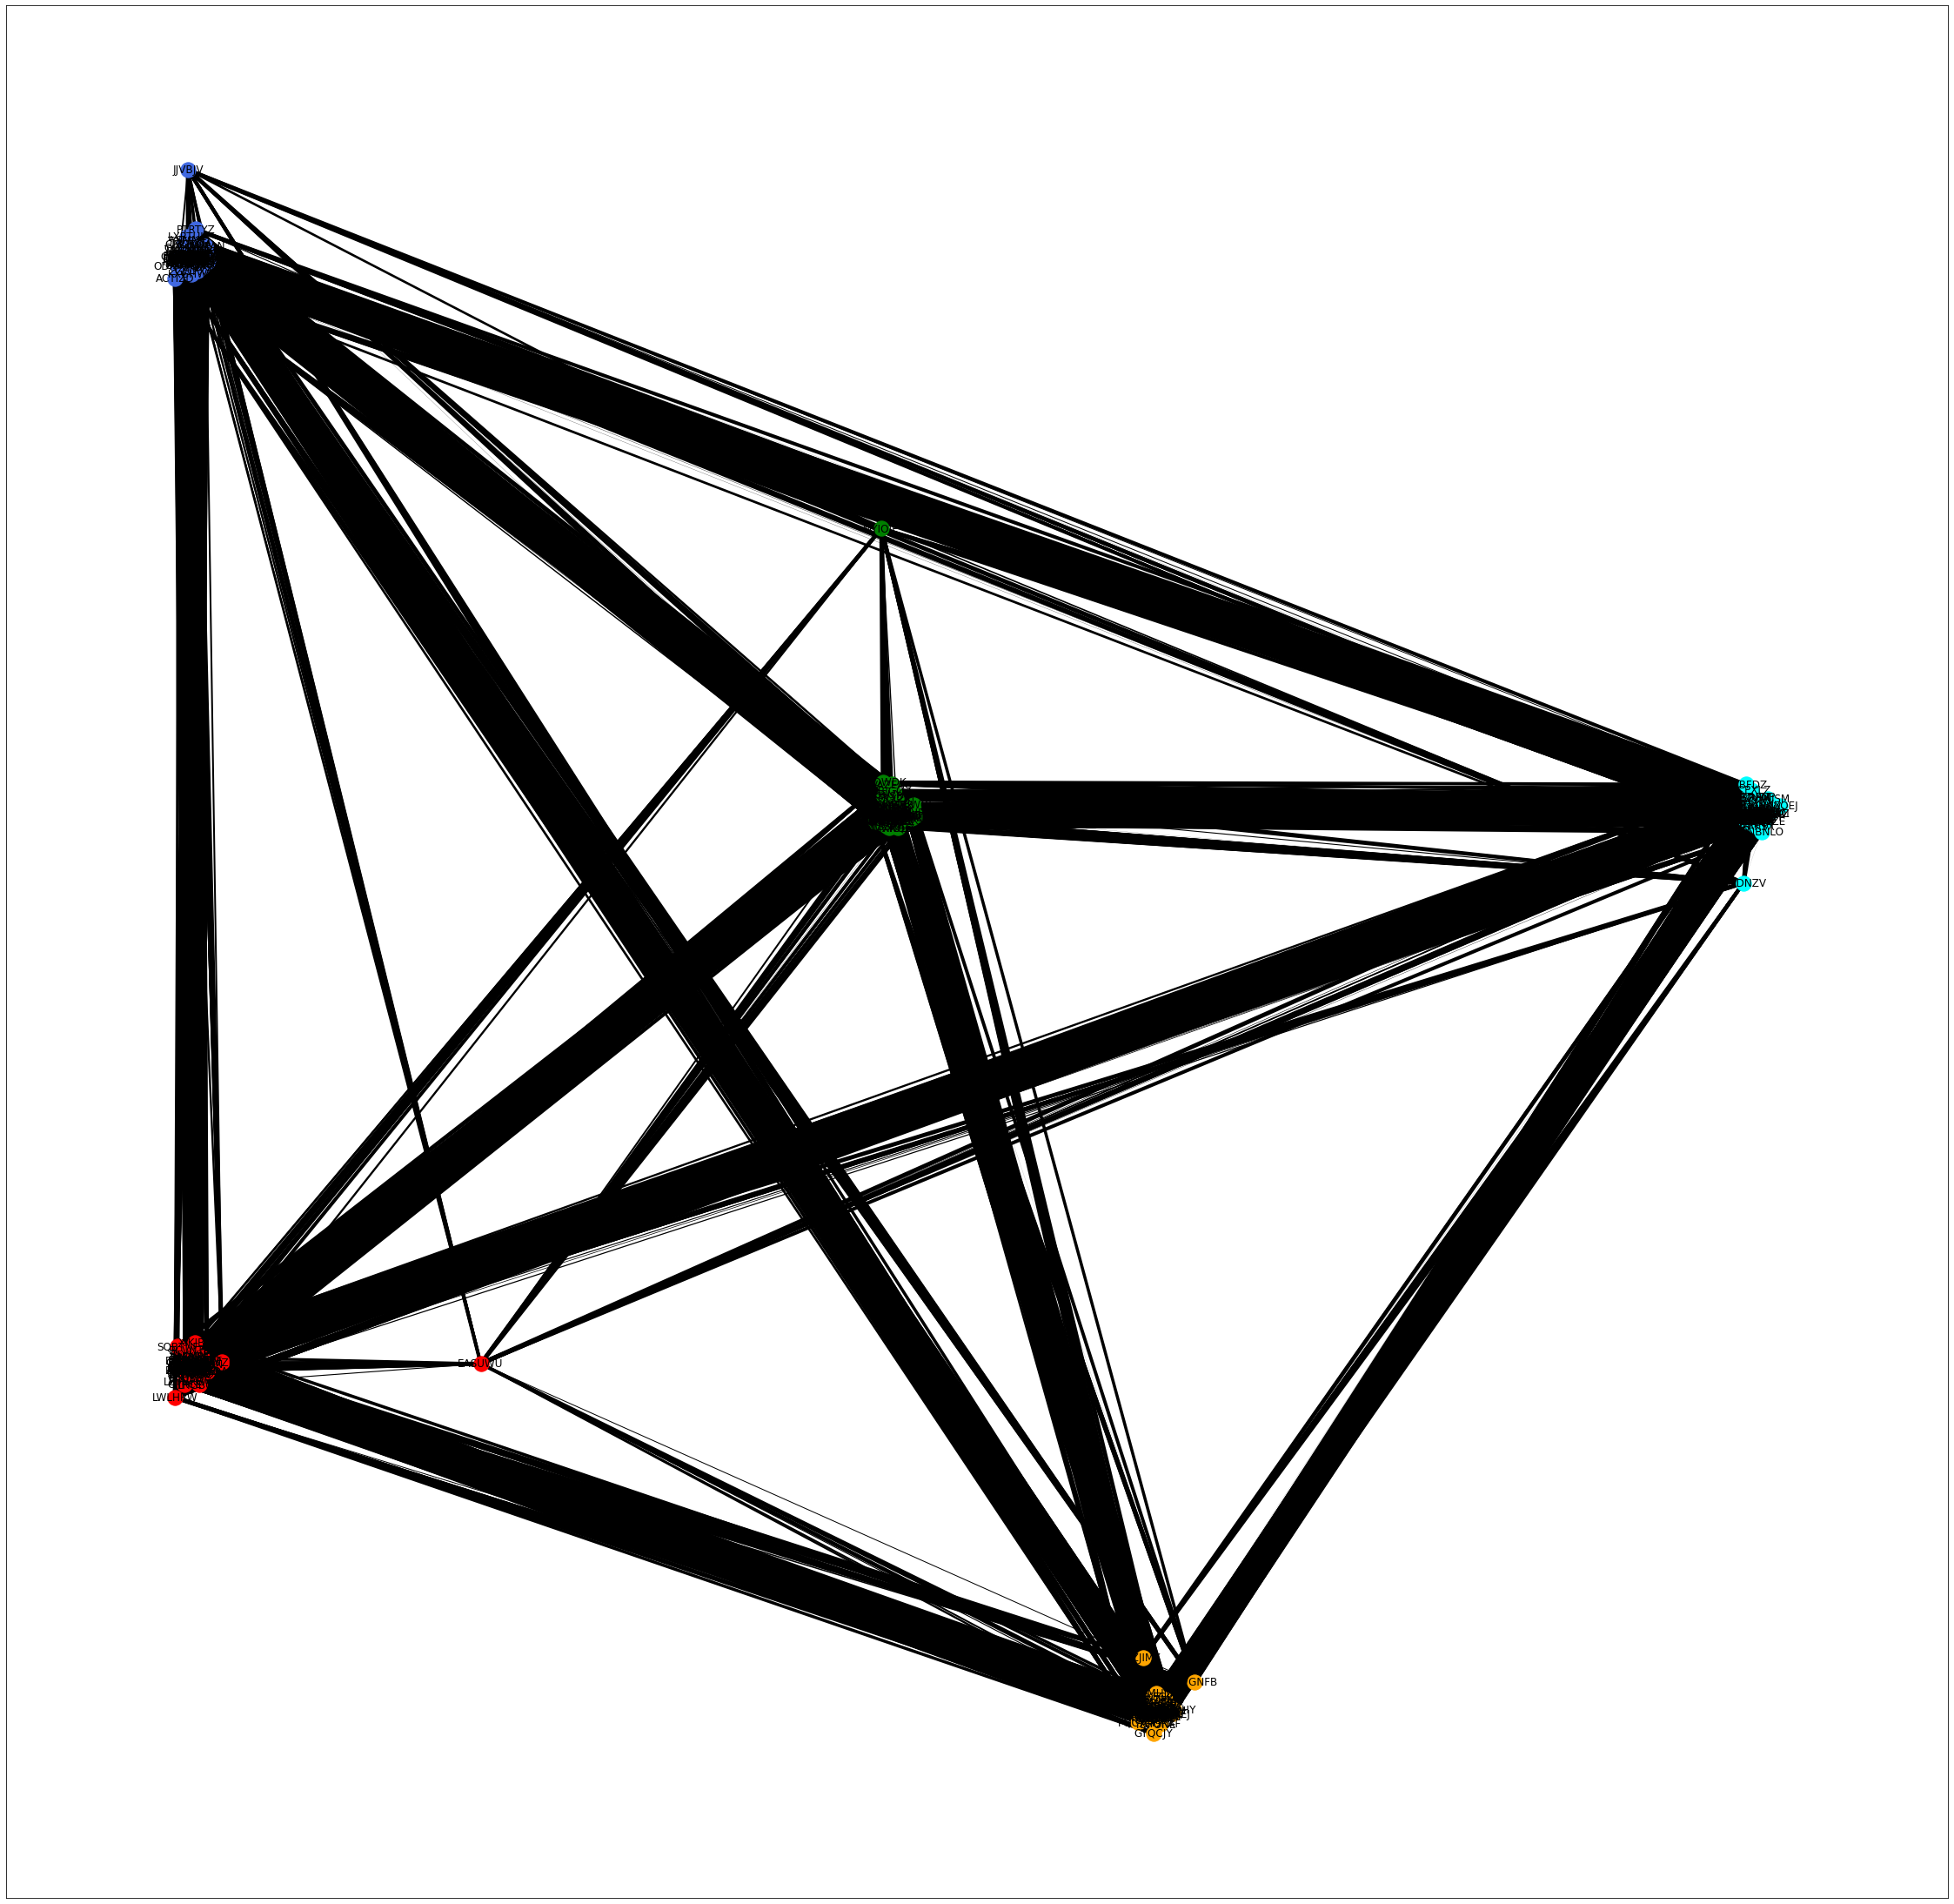

In [121]:
import string, random
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random
from matplotlib.pyplot import figure

figure(figsize=(100, 80), dpi=80)

# Random string generator
def rand_string(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))


# Set up a nodes and networks randomly
nodes = [rand_string() for _ in range(300)]
networks = [rand_string() for _ in range(5)]
networks_list = networks*60
random.shuffle(networks_list)

# Define what nodes belong to what network and what their color should be
node_network_map = dict(zip(nodes, networks_list))
colors = ['green', 'royalblue', 'red', 'orange', 'cyan']
color_map = dict(zip(networks, colors))

graph = nx.Graph()
graph.add_nodes_from(nodes)
nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
                  for val in colors}

# # Take random sparse matrix as adjacency matrix
mat = sparse_random(300, 300, density=0.3).todense()
for row, row_val in enumerate(nodes):
    for col, col_val in enumerate(nodes):
        if col > row and mat[row, col] != 0.0: # Stick to upper half triangle, mat is not symmetric
            graph.add_edge(row_val, col_val, weight=mat[row, col])

# Choose a layout to visualize graph
pos = nx.spectral_layout(graph)   # replaces your original pos=...
# prep center points (along circle perimeter) for the clusters
angs = np.linspace(0, 2*np.pi, 1+len(colors))
repos = []
rad = 3     # radius of circle
for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
        # repos.append(np.array([np.cos(ea), np.sin(ea)]))
for ea in pos.keys():
    #color = 'black'
    posx = 0
    if ea in nodes_by_color['green']:
        #color = 'green'
        continue
    elif ea in nodes_by_color['royalblue']:
        #color = 'royalblue'
        posx = 1
    elif ea in nodes_by_color['red']:
        #color = 'red'
        posx = 2
    elif ea in nodes_by_color['orange']:
        #color = 'orange'
        posx = 3
    elif ea in nodes_by_color['cyan']:
        #color = 'cyan'
        posx = 4
    else:
        pass
    print(ea, pos[ea], repos[posx], pos[ea]+repos[posx], color, posx)
    pos[ea] += repos[posx]
edges = graph.edges()

# Get the edge weights and normalize them 
# weights = [abs(graph[u][v]['weight']) for u, v in edges]
# weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

# First draw the nodes 
plt.figure(figsize=(40,40))
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=node_names, node_color=color)

# Then draw edges with thickness defined by weights_n
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()

# 
# pyvis_nt = Network("10000px", "10000px", heading="Graph")
# pyvis_nt.from_nx(graph, pos=pos)
# pyvis_nt.show('test_graph.html')

In [124]:
color_map = {
    "contributor": '#000000',
    "0":'#9699b6',
    "1":'#097f62',
    "2":'#9f69e5',
    "3":'#6c4605',
    "4":'#5d6034',
    "5":'#a4b769',
    "6":'#034dba',
    "7":'#8b370e',
    "8":'#9b8c3e',
    "9":'#964980',
}

In [125]:
len(color_map)

11

In [93]:
repos[posx]

array([1.08155948, 3.32869781])

In [97]:
pos[ea]

array([2.05970705, 3.12078606])

In [81]:
pos = nx.circular_layout(graph) 

In [82]:
pos

{'BCDQYR': array([1.00000e+00, 1.28482e-08]),
 'JNXPQZ': array([0.97814763, 0.20791171]),
 'WRCREV': array([0.91354543, 0.40673665]),
 'AZHWCW': array([0.809017  , 0.58778526]),
 'TZLSQO': array([0.66913056, 0.74314488]),
 'GLFXEL': array([0.49999997, 0.86602546]),
 'MALTFO': array([0.30901697, 0.95105655]),
 'UJYXSL': array([0.10452842, 0.99452193]),
 'YLTBVB': array([-0.10452851,  0.99452193]),
 'UEODDK': array([-0.30901703,  0.95105649]),
 'BXGUIR': array([-0.50000006,  0.8660254 ]),
 'SJYWFS': array([-0.66913068,  0.74314476]),
 'FMNWRR': array([-0.809017  ,  0.58778526]),
 'VYDOKZ': array([-0.91354549,  0.40673659]),
 'EMOQWL': array([-0.97814762,  0.20791162]),
 'YHJAMN': array([-9.99999998e-01, -7.45745765e-08]),
 'CIPXSL': array([-0.97814756, -0.20791178]),
 'QPVIHL': array([-0.91354543, -0.40673672]),
 'EOTHFN': array([-0.80901694, -0.58778529]),
 'UBTWZC': array([-0.6691305 , -0.74314486]),
 'NWFDEU': array([-0.49999991, -0.86602543]),
 'FNVZWA': array([-0.30901712, -0.951056

In [64]:
graph_dict = {}
graph_dict["edges"] = list(pos.keys())
graph_dict["x_coordinate"] = [item[0]*1000 for item in list(pos.values())]
graph_dict["y_coordinate"] = [item[1]*1000 for item in list(pos.values())]

In [65]:
g = Network()
g.add_nodes(graph_dict["edges"], 
            # value=[10, 100, 400],
            # title=['I am node 1', 'node 2 here', 'and im node 3'],
            x=graph_dict["x_coordinate"],
            y=graph_dict["y_coordinate"],
            # label=['NODE 1', 'NODE 2', 'NODE 3'],
            # color=['#00ff1e', '#162347', '#dd4b39']
            )
g.show('test_graph3.html')

In [63]:
g = Network()
g.add_nodes([1,2,3], 
            # value=[10, 100, 400],
            # title=['I am node 1', 'node 2 here', 'and im node 3'],
            x=[21.4, 54.2, 11.2],
            y=[100.2, 23.54, 1032.1],
            label=['NODE 1', 'NODE 2', 'NODE 3'],
            color=['#00ff1e', '#162347', '#dd4b39'])
g.show('test_graph2.html')

In [80]:
from pyvis.network import Network

g = Network()
g.add_nodes([1, 2, 3],
            value=[1, 1, 1],
            title=["I am node 1", "node 2 here", "and im node 3"],
            x=[0, 100, 100],
            y=[0, 100, 200], label=["NODE 1", "NODE 2", "NODE 3"],
            color=["#00ff1e", "#162347", "#dd4b39"])

g.show('just_nodes.html')

g.add_edge(1, 2)
g.add_edge(1, 3)

g.show('with_edges.html')

for n in g.nodes:
    n.update({'physics': False})

g.show('with_edges_and_physics.html')

{0: Text(-0.9987429475918784, -0.35020835947619644, '0'),
 1: Text(-0.23141723201825112, -0.12620422302094197, '1'),
 2: Text(0.14393301288764032, 0.8721407492324282, '2'),
 3: Text(-0.6912915793791871, 0.596826748568767, '3'),
 4: Text(-0.14338054040765238, -0.8695649009622017, '4'),
 5: Text(0.2315420964331387, 0.1246526945489983, '5'),
 6: Text(1.0, 0.3510448679482861, '6'),
 7: Text(0.6893571900761896, -0.5986875768391395, '7')}

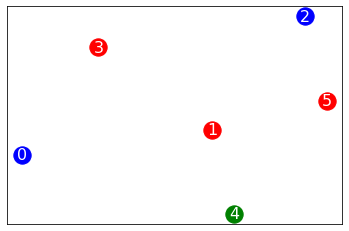

In [27]:
G = nx.cubical_graph()
pos = nx.spring_layout(G)

nodes = {
    'r': [1, 3, 5],
    'b': [0, 2],
    'g': [4]
}
for node_color, nodelist in nodes.items():
    nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_color)

labels = {x: x for x in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')

In [20]:
G[1][3]['color']='blue'

KeyError: 1

In [19]:
G[-1001506638003]['color']='blue'


TypeError: 'AtlasView' object does not support item assignment

In [34]:
type(-1001506638003)

int

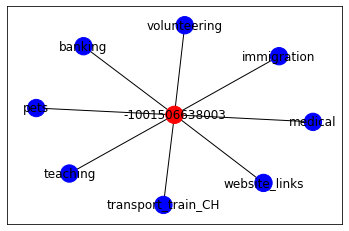

In [43]:
nx.draw_networkx(G, node_color=color_map, with_labels=True)

In [ ]:
net = Network(notebook=True)
net.from_nx(G_symmetric)
net.show("example.html")

In [11]:
from pyvis.network import Network

g = Network()
g.add_node(0)
g.add_node(1)
g.add_edge(0, 1)
g.show("basic.html")

In [ ]:
net.show("example.html")

In [42]:
color_map = []
for node in G:
    print(node, type(node))
    if isinstance(node, int):
        color_map.append('red')
    if isinstance(node, str):
        color_map.append('blue')

-1001506638003 <class 'int'>
website_links <class 'str'>
teaching <class 'str'>
transport_train_CH <class 'str'>
immigration <class 'str'>
banking <class 'str'>
pets <class 'str'>
volunteering <class 'str'>
medical <class 'str'>


In [ ]:
for node in G

color_map = []
for node in G:
    if node < 10:
        color_map.append('blue')
    else: 
        color_map.append('green')      
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()